In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.data.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 5
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 100
renorm_first = False
scale_first_lr = False

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
ipllrs = [FcIPLLR(base_model_config, n_warmup_steps=12, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
base_model_config.scheduler = None
muPs = [FCmuP(base_model_config) for _ in range(N_TRIALS)]

if scale_first_lr:
    if renorm_first:
        for muP in muPs:
            for i, param_group in enumerate(muP.optimizer.param_groups):
                if i == 0:
                    param_group['lr'] = param_group['lr'] * (muP.d + 1)
        
        for ipllr in ipllrs:
            ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

initial base lr : [69.26097106933594, 36.901771545410156, 60.06058120727539, 61.465023040771484, 69.81842803955078, 80.47272491455078, 242.21490478515625]
initial base lr : [68.2101821899414, 38.062652587890625, 67.09164428710938, 72.38660430908203, 78.3447494506836, 93.293212890625, 289.7236633300781]
initial base lr : [69.08634948730469, 38.01998519897461, 66.5303726196289, 69.7338638305664, 72.82850646972656, 86.75313568115234, 247.78399658203125]
initial base lr : [69.98839569091797, 38.506282806396484, 67.24036407470703, 63.19353485107422, 76.40673065185547, 94.85008239746094, 269.35626220703125]
initial base lr : [68.72810363769531, 36.14960479736328, 60.415069580078125, 66.5676498413086, 64.38241577148438, 73.41007995605469, 205.81072998046875]


In [9]:
for i, ipllr in enumerate(ipllrs):
    ipllr.copy_initial_params_from_model(muPs[i])
    ipllr.initialize_params()

In [10]:
for ipllr in ipllrs:
    ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches)

initial base lr : [71.29985809326172, 39.601322174072266, 69.07202911376953, 68.32510375976562, 74.03070068359375, 102.55863189697266, 309.83807373046875]
initial base lr : [65.86217498779297, 39.934505462646484, 67.1400375366211, 72.8635025024414, 78.6200942993164, 90.54925537109375, 290.7981872558594]
initial base lr : [72.4135971069336, 37.74406433105469, 58.522464752197266, 65.41656494140625, 75.37728118896484, 83.77339172363281, 227.68858337402344]
initial base lr : [76.4921875, 42.94648361206055, 72.16778564453125, 76.09686279296875, 83.21685028076172, 115.44151306152344, 353.1344299316406]
initial base lr : [75.93328094482422, 41.4957275390625, 71.97281646728516, 69.65848541259766, 77.32459259033203, 93.4665298461914, 264.848388671875]


In [11]:
muPs_0 = [deepcopy(muP) for muP in muPs]

x, y = batches[0]
for muP in muPs:
    train_model_one_step(muP, x, y, normalize_first=renorm_first)

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9477,  0.0482,  0.1288,  ...,  0.2324,  0.0795,  0.1538],
        [ 0.0310, -0.9162,  0.1086,  ...,  0.1890,  0.0589,  0.0973],
        [ 0.0589,  0.0608,  0.1298,  ...,  0.1236,  0.1017, -0.8108],
        ...,
        [ 0.0405,  0.1111,  0.0929,  ...,  0.2307,  0.0597, -0.8816],
        [ 0.0534,  0.0563,  0.1156,  ...,  0.2101,  0.0675,  0.2060],
        [ 0.0321,  0.0632,  0.0537,  ...,  0.1351, -0.8939,  0.1009]])
average training loss for model1 : 2.552438497543335

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9150,  0.0558,  0.3221,  ...,  0.0809,  0.0985,  0.0998],
        [ 0.1066, -0.9465,  0.2270,  ...,  0.0740,  0.0312,  0.2768],
        [ 0.0632,  0.0867,  0.1854,  ...,  0.0424,  0.0881, -0.8089],
        ...,
        [ 0.1137,  0.0625,  0.2635,  ...,  0.0743,  0.0253, -0.7905],
        [ 0.0516,  0.0471,  0.1178,  ...,  0.0545,  0.0784,  0.5128

In [12]:
x, y = batches[0]
ipllrs_1 = []
for ipllr in ipllrs:
    train_model_one_step(ipllr, x, y, normalize_first=renorm_first)
    ipllrs_1.append(deepcopy(ipllr))

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000]])
average training loss for model1 : 2.3025991916656494

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.100

In [13]:
results = {'muP': [], 'IPLLR': []}
results['muP'] = [collect_scales(muPs[i], muPs_0[i], batches[1:], eval_batch, n_steps, 
                                 normalize_first=renorm_first) 
                  for i in range(N_TRIALS)]

In [14]:
results['IPLLR'] = [collect_scales(ipllrs[i], ipllrs_1[i], batches[1:], eval_batch, n_steps, 
                                   normalize_first=renorm_first) 
                    for i in range(N_TRIALS)]

AssertionError: With rtol=0.001 and atol=1.0, found 12 element(s) (out of 524288) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 93.8984375 (-92825.1484375 vs. -92731.25), which occurred at index (212, 949).

# Training

In [ ]:
mode = 'training'

In [ ]:
losses_muP = [r[0] for r in results['muP']]
losses_ip = [r[0] for r in results['IPLLR']]

chis_muP = [r[1] for r in results['muP']]
chis_ip = [r[1] for r in results['IPLLR']]

## Losses and derivatives

In [ ]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
            normalize_first=renorm_first)
plt.savefig(
    os.path.join(FIGURES_DIR, 
                 '{}_{}_L={}_m={}_lr={}_bs={}_renorm={}_scale_lr={}.png'.format(mode, key, L, width, base_lr, 
                                                                            batch_size, renorm_first, 
                                                                                scale_first_lr)))
plt.show()

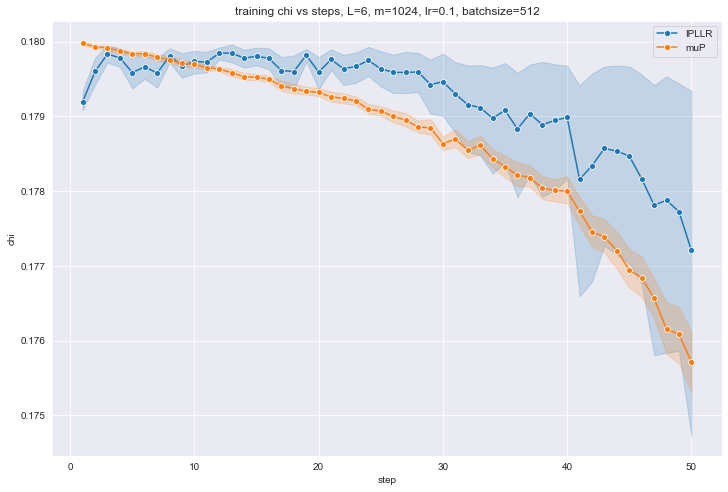

In [20]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [21]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

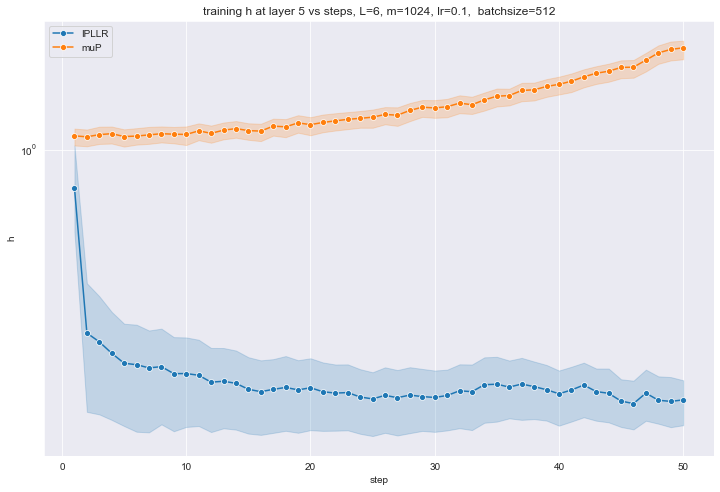

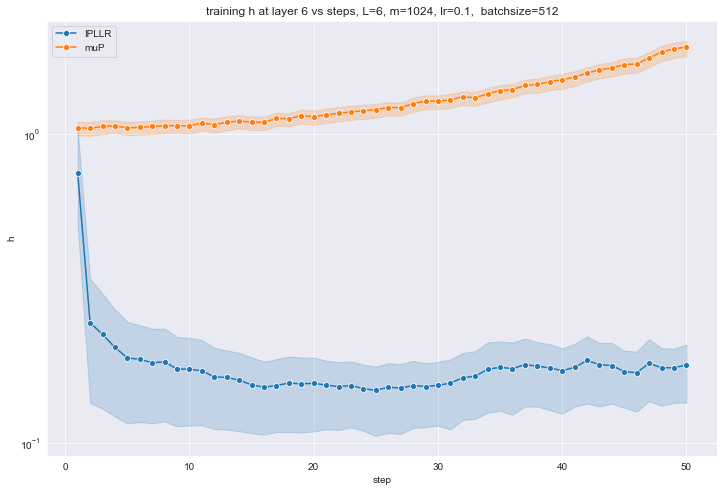

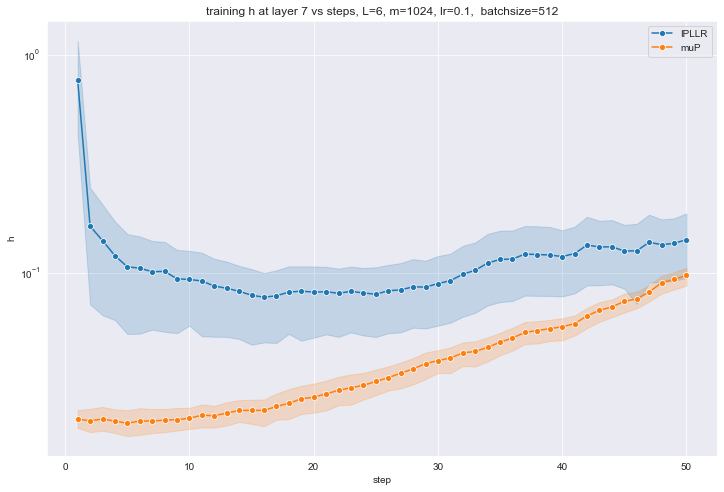

In [22]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

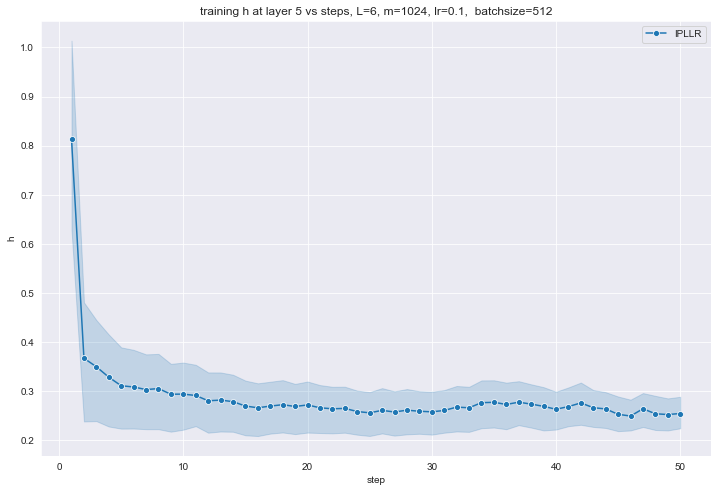

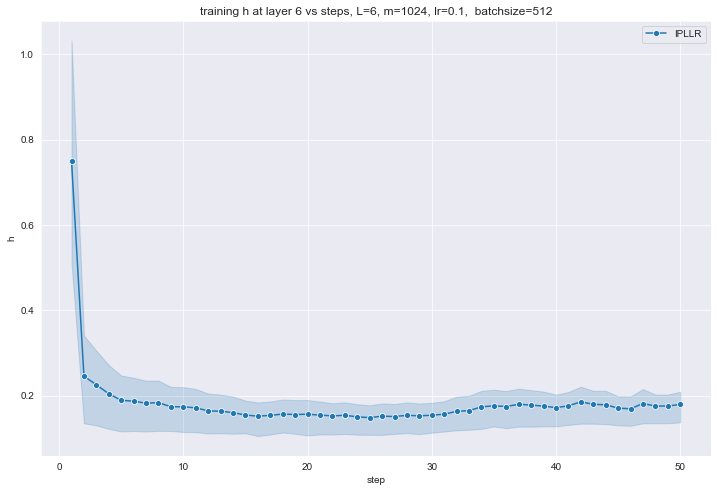

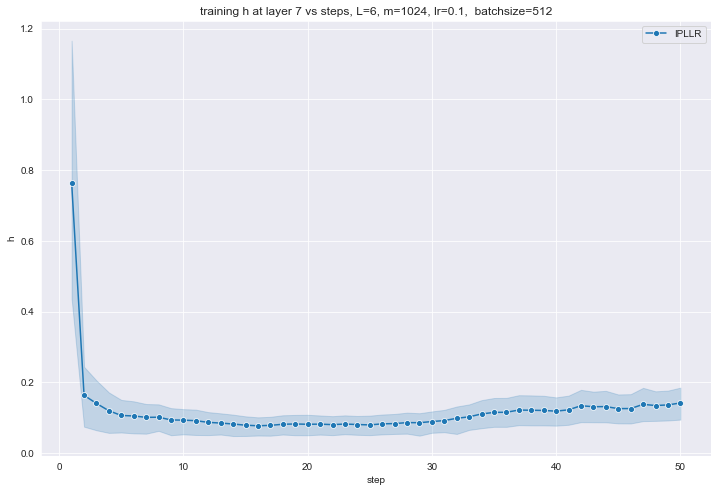

In [23]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

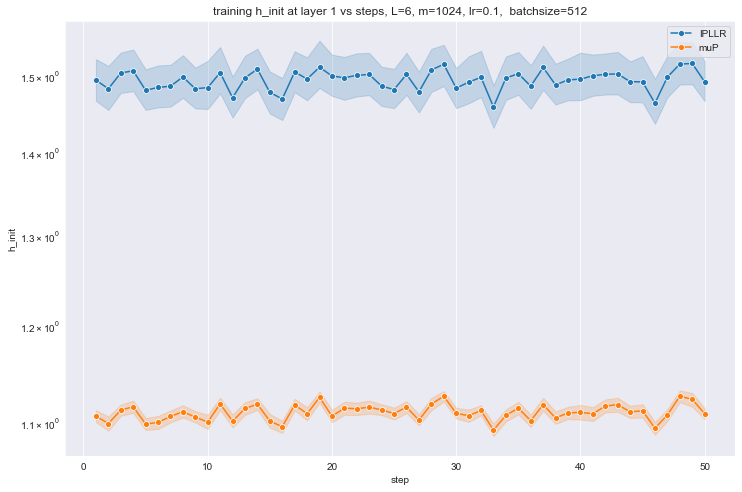

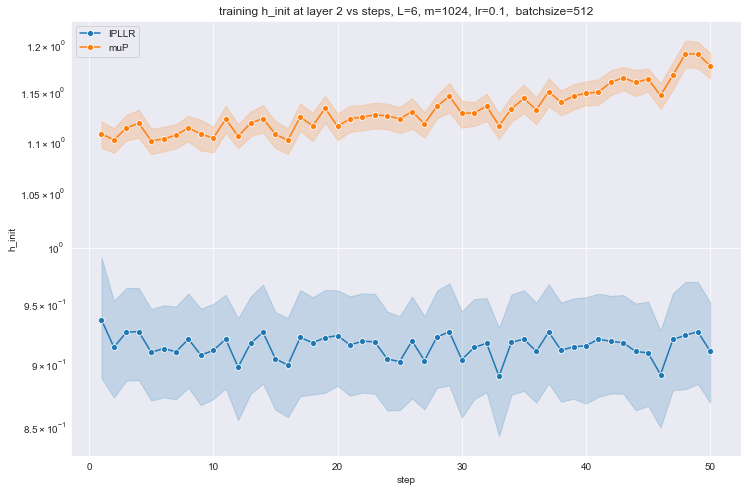

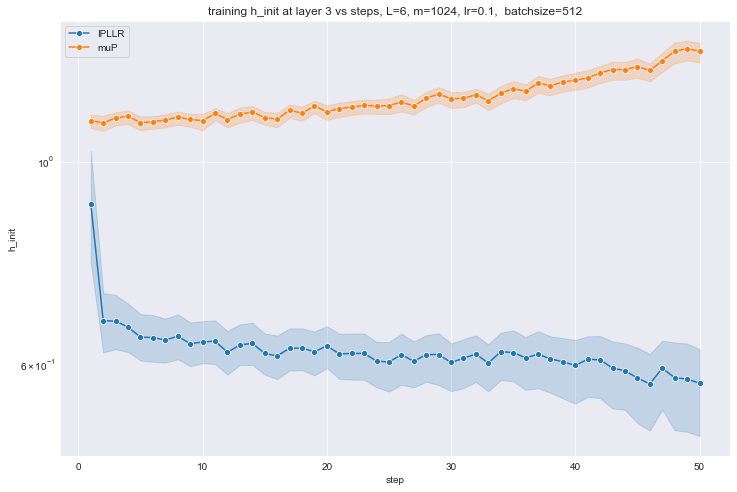

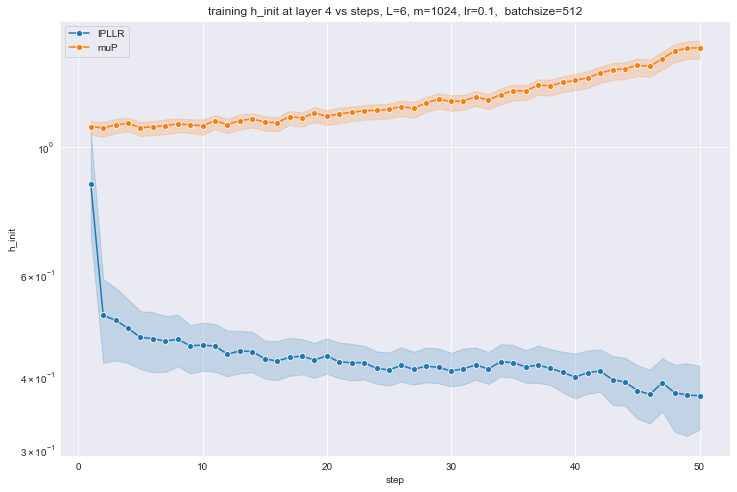

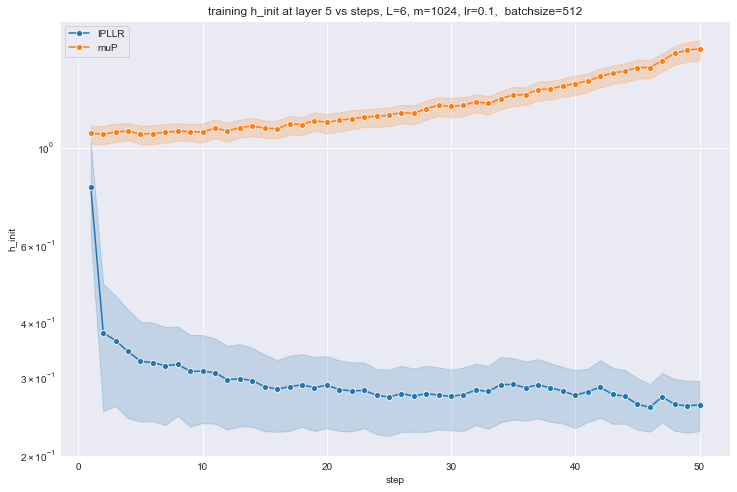

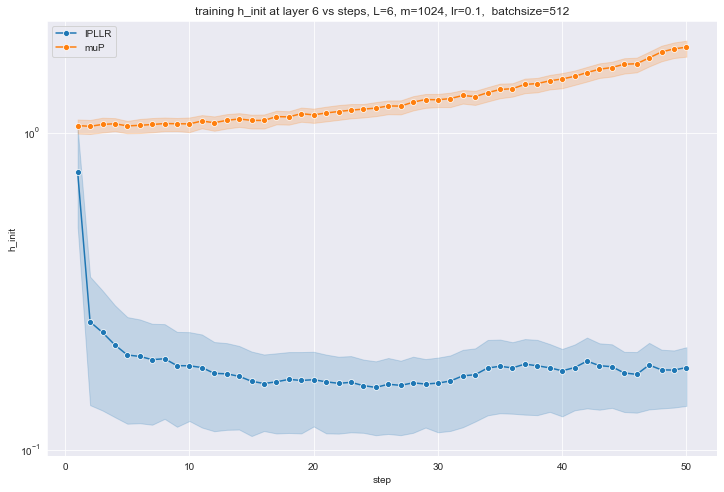

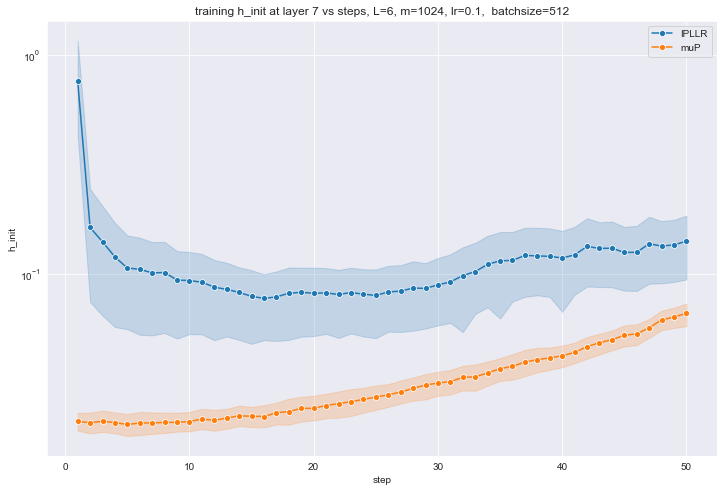

In [24]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

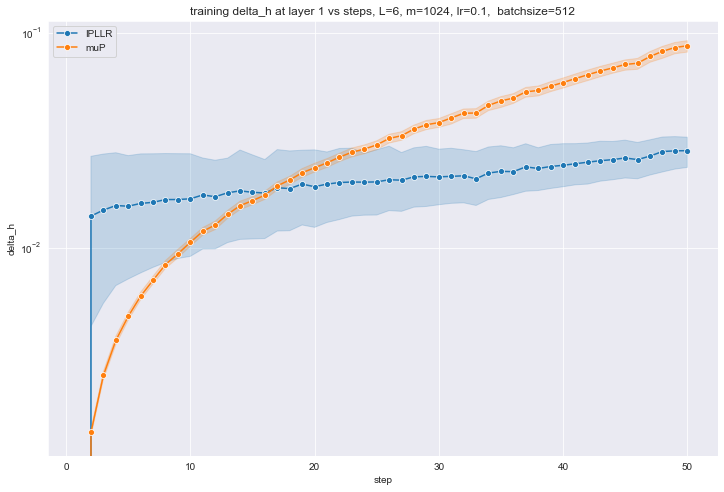

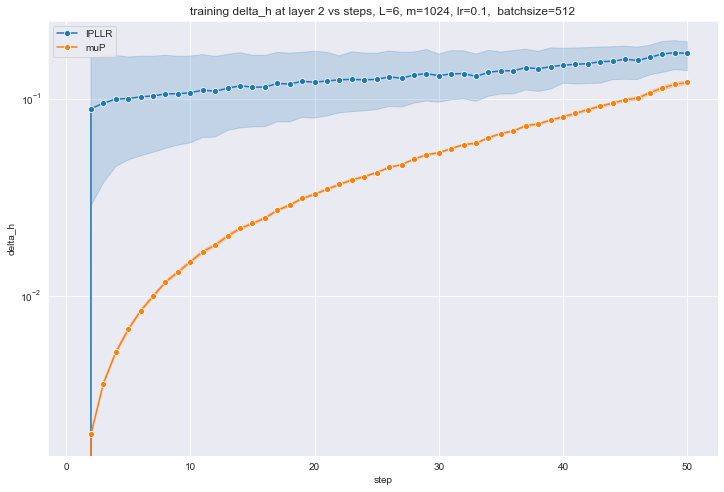

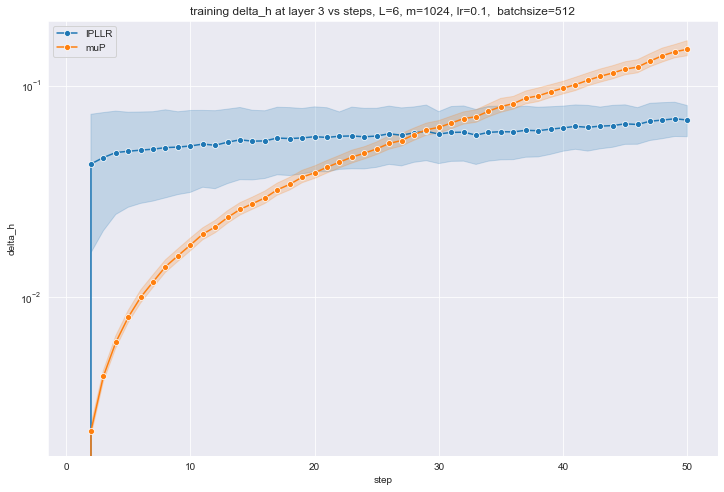

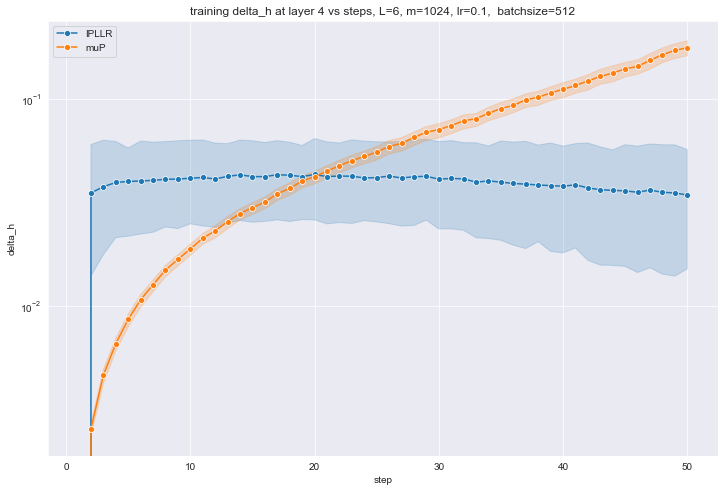

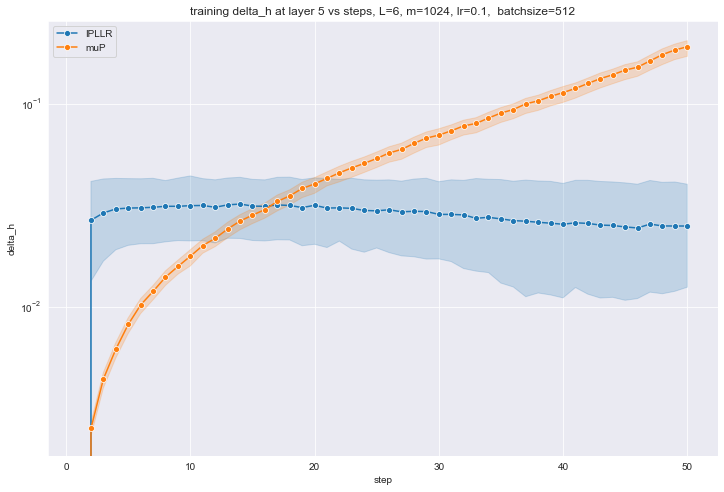

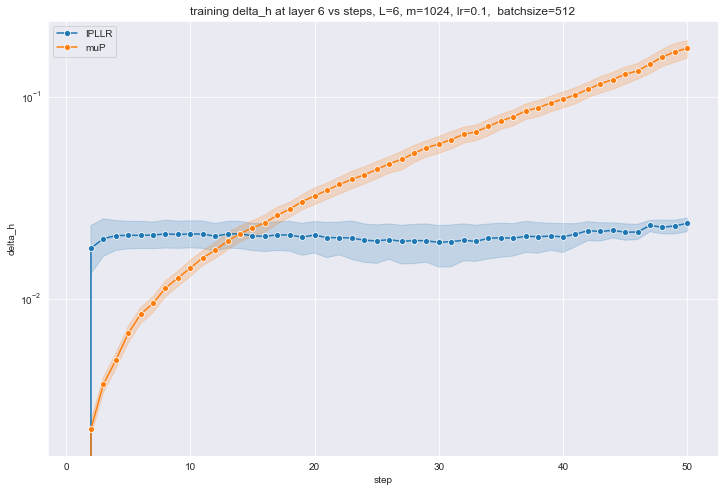

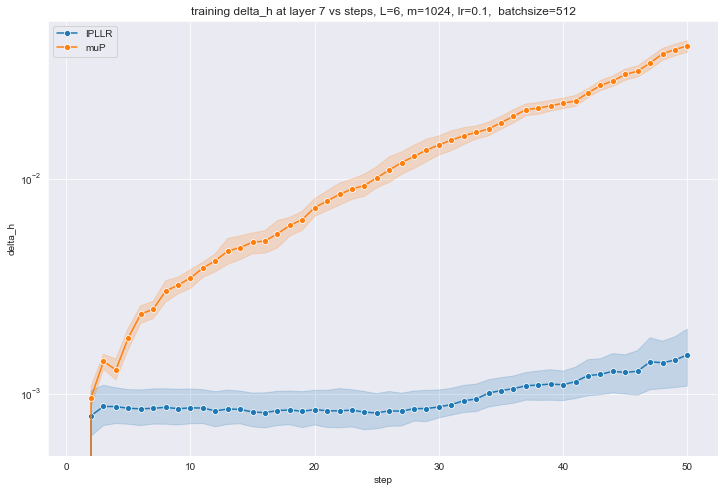

In [25]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

# Validation

In [26]:
mode = 'val'

In [27]:
dfs_muP = [r[3] for r in results['muP']]
dfs_ip = [r[3] for r in results['IPLLR']]

## Losses and derivatives

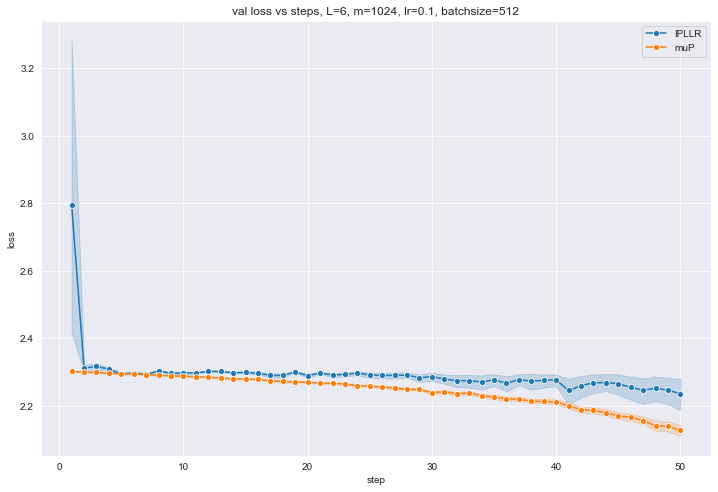

In [28]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

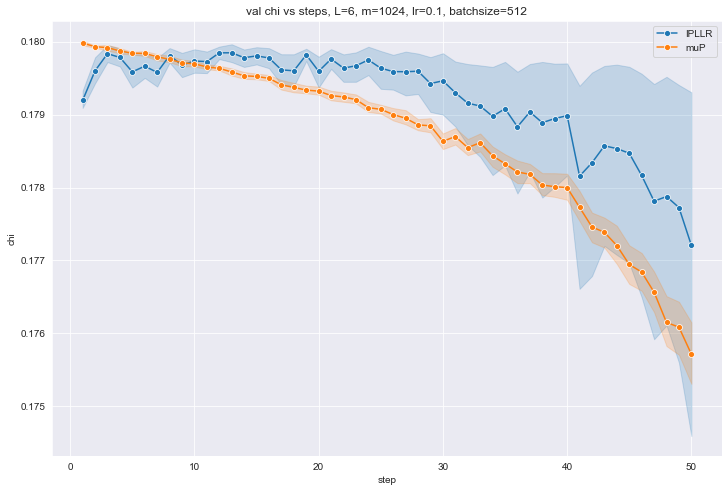

In [29]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [30]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

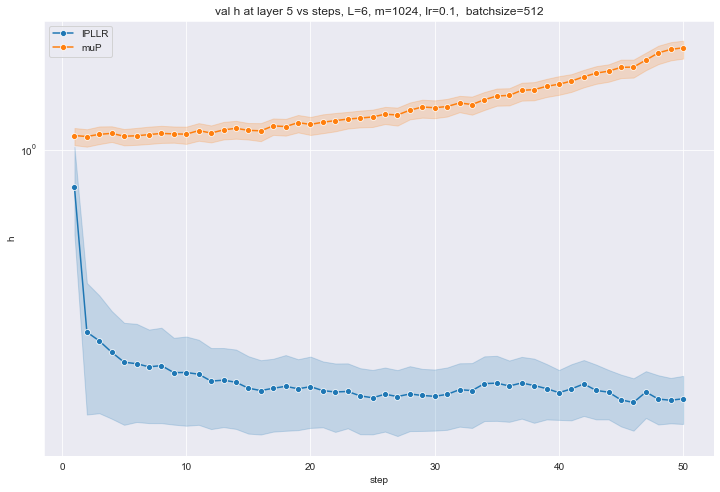

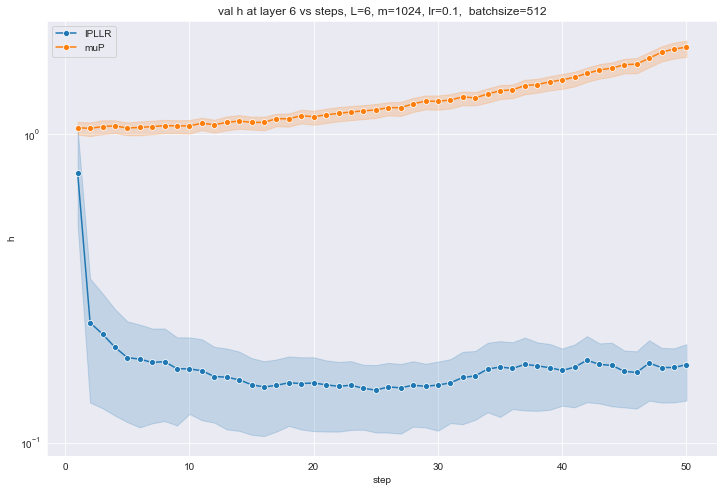

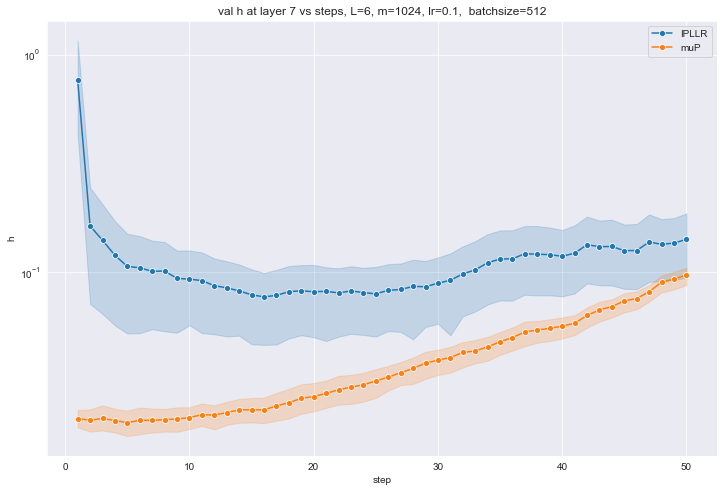

In [31]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

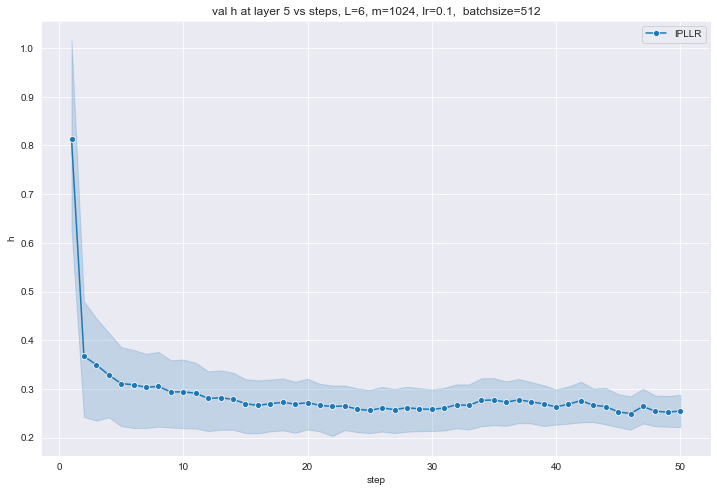

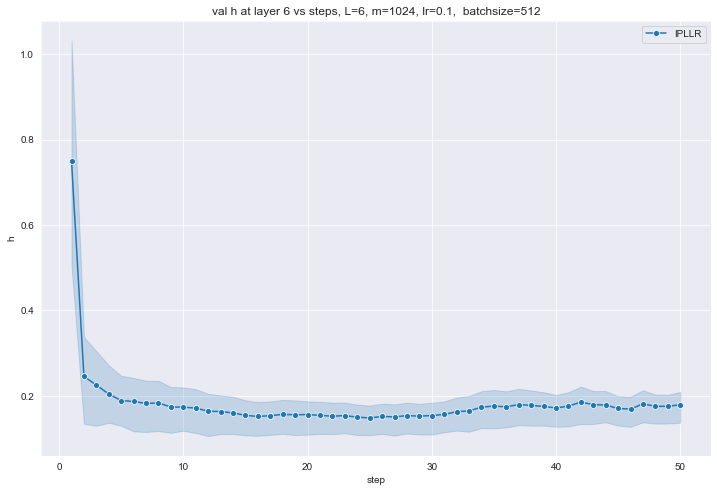

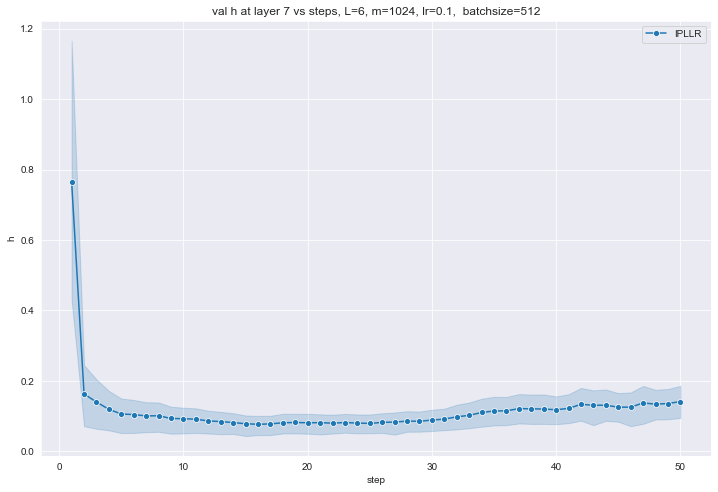

In [32]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

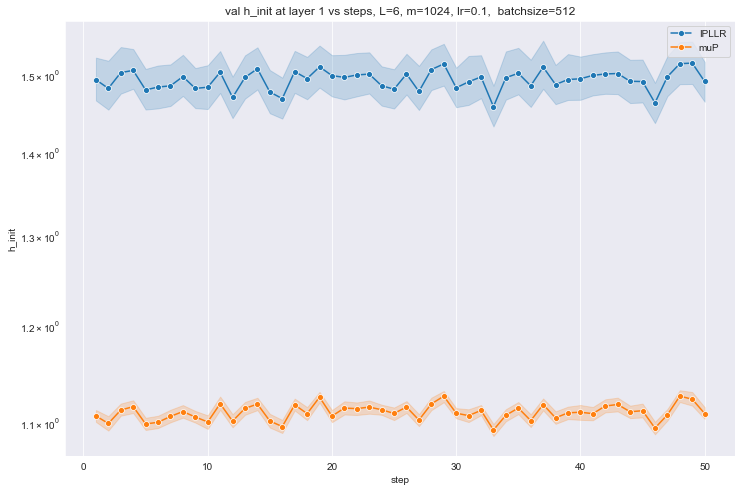

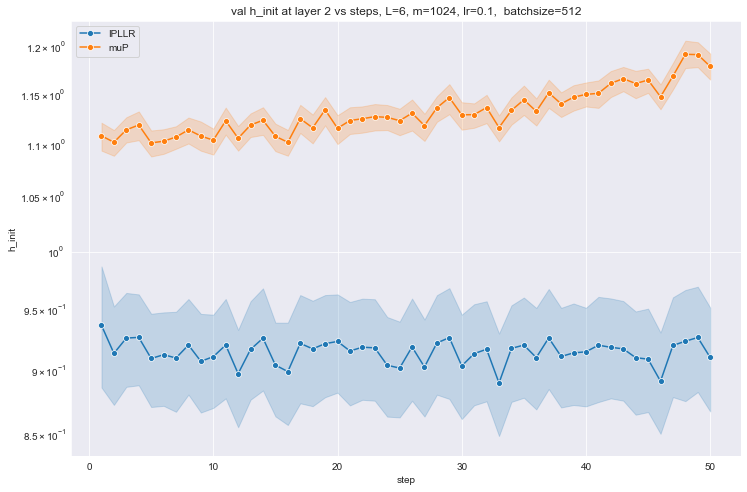

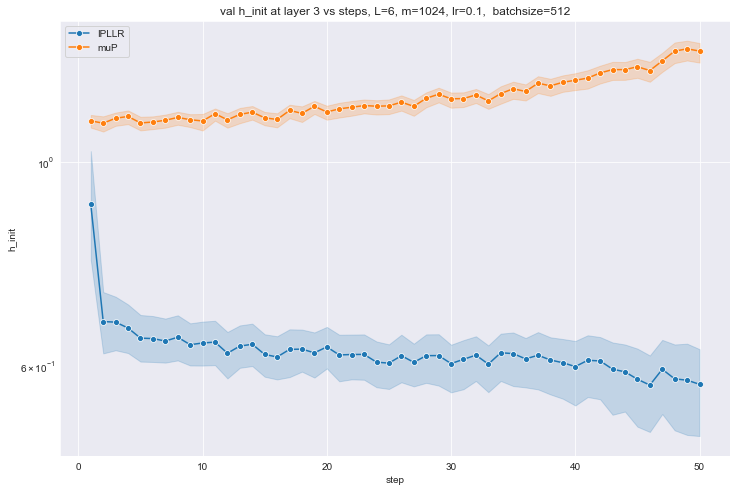

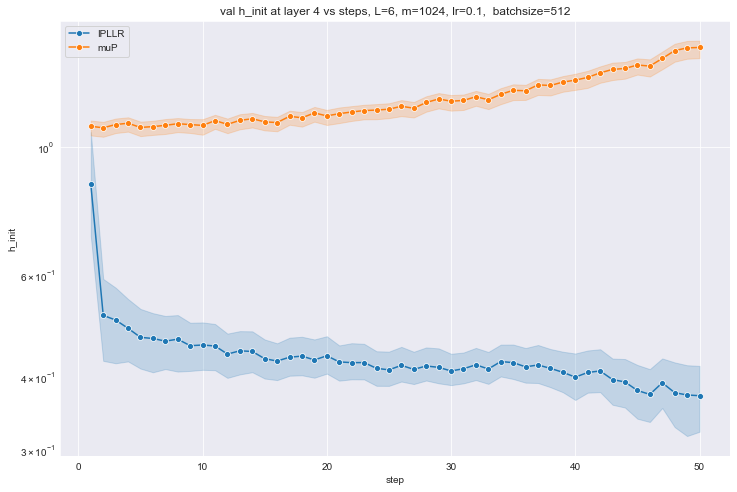

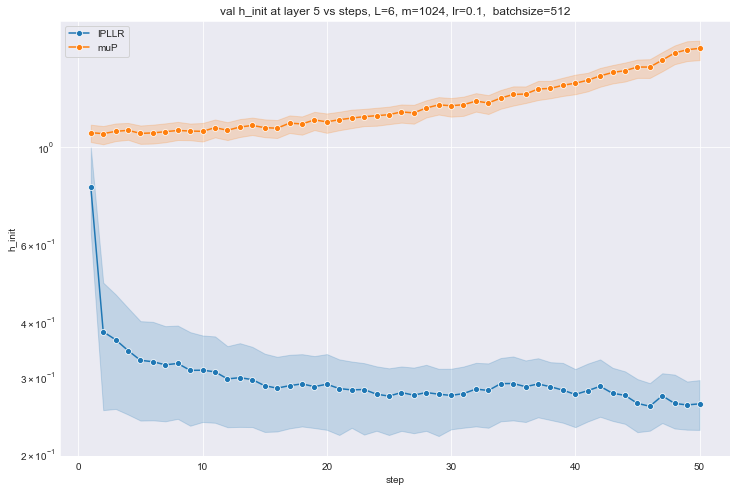

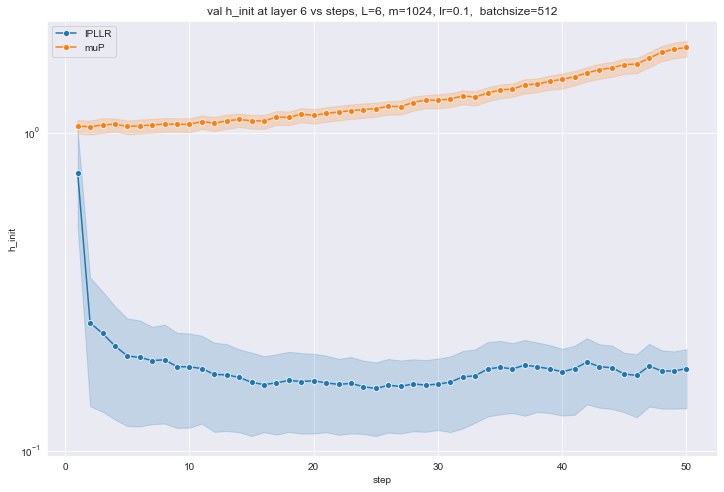

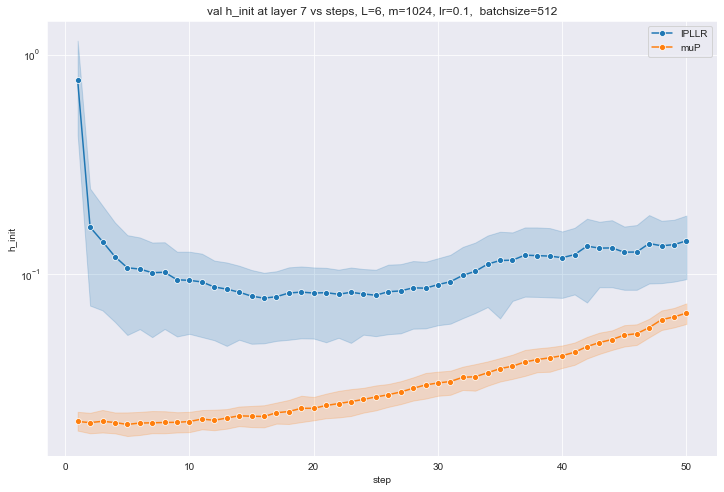

In [33]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

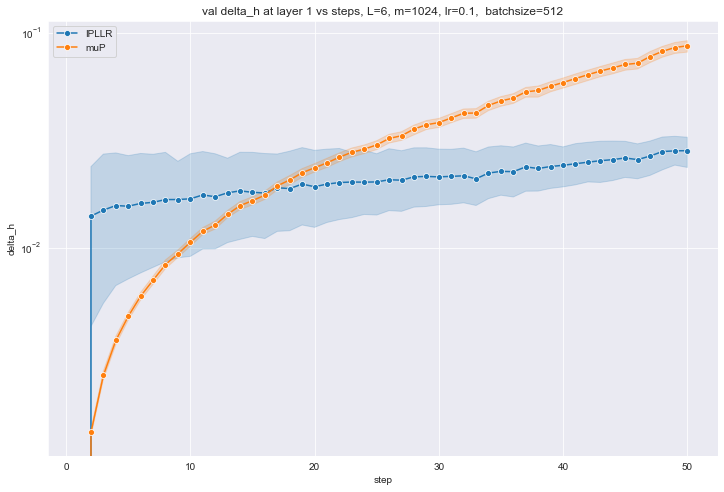

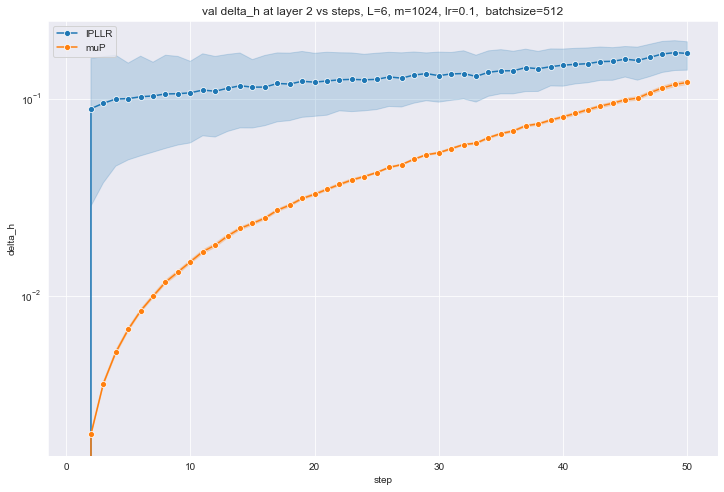

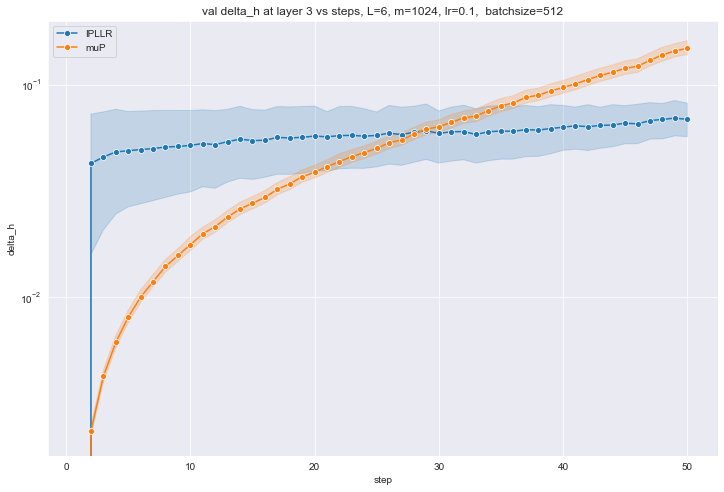

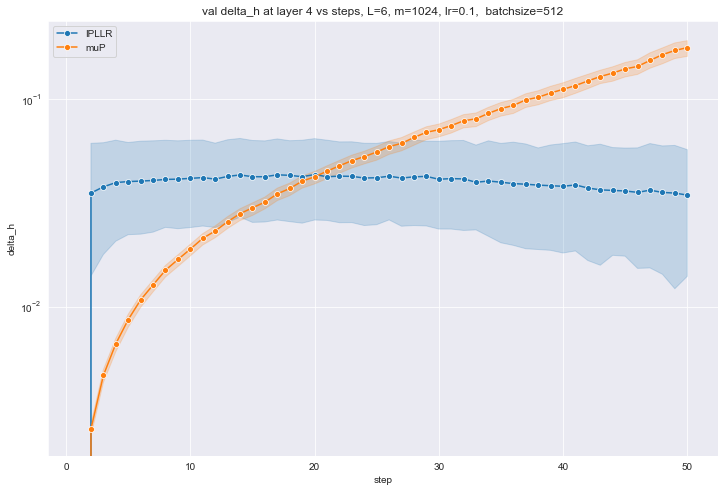

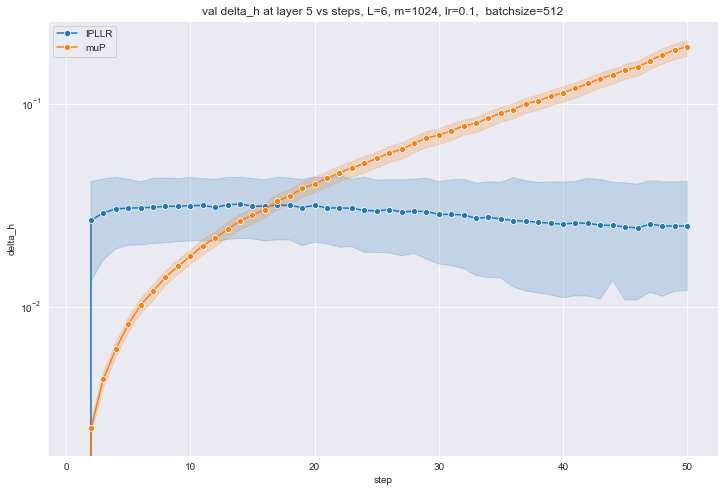

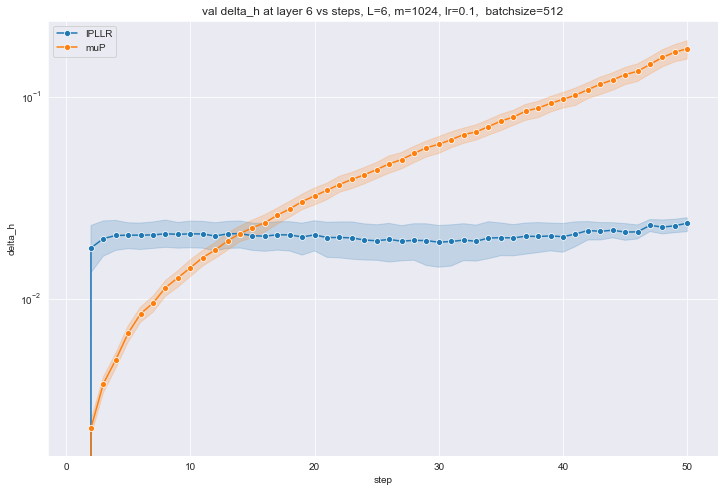

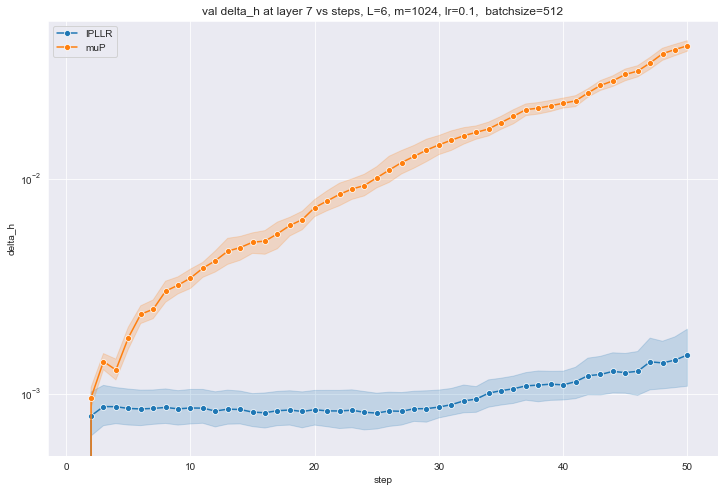

In [34]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()